# Predicting Brain Pathology in Alzheimer's Disease using Elastic Net Regression

The notebook details an analysis using elastic net regression to predict brain pathology score (amyloid, tangles, gpath, and NIA-Reagan scores) in Alzheimer's disease based on clinical features (e.g. cognitive test scores, underlying health conditions, demographic) from last visit before deceased. 

The analysis aims to create a baseline model for future comparisons with lstm model.

- Inputs:
    - scaled_train_last.pkl, scaled_test_last.pkl

- Results: 
    - predicit gpath:
      - the selected parameters:
        - alpha: 0.1
        - l1 ratio: 0.3
      - Testing $R^2$: 0.2619
    - predicit tangles:
        - the selected parameters:
          - alpha: 0.1
          - l1 ratio: 0.1
        - Testing $R^2$: 0.3854


# Analysis Steps
- Elastic-Net Regression Used participants' last visit data.
    - Parameter Tuning: GridSearchCV to optimize hyperparameters.
    - Model Fitting: Applied best parameters to fit the elastic net model.
    - Performance Evaluation: Evaluated the model on testing data.

# Set up

In [1]:
import utils
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# --- 1. Define Paths ---
INPUT_DIR = utils.RESULTS_DIR / "S1" / "S1.1"
OUTPUT_DIR = utils.RESULTS_DIR / "S2"

# Auto-create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Reading inputs from: {INPUT_DIR}")
print(f"Saving outputs to: {OUTPUT_DIR}")

# --- 2. Load Data ---
train_path = INPUT_DIR / "NIAvalueUpdatedVersion_scaled_train_last.pkl"
test_path  = INPUT_DIR / "NIAvalueUpdatedVersion_scaled_test_last.pkl"

if not train_path.exists():
    raise FileNotFoundError(f"Input file not found: {train_path}")
if not test_path.exists():
    raise FileNotFoundError(f"Input file not found: {test_path}")

scaled_train_last = pd.read_pickle(train_path)
scaled_test_last  = pd.read_pickle(test_path)

Reading inputs from: /Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/results/S1/S1.1
Saving outputs to: /Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/results/S2


# 1. Perform GLM elastic-net using last visit

## 1.1 Parameter Tuning with GridSearchCV

In [2]:
# Define the parameter grid
param_grid = {
    'alpha': np.logspace(-3, 0, 10).astype(float).round(3),
    'l1_ratio': np.arange(0.0, 0.45, 0.05).astype(float).round(2)
}

# Use the custom model wrapper
elastic_net_ridge_switcher = utils.ElasticNetRidgeSwitcher()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic_net_ridge_switcher,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available cores
)

In [3]:
# List of outcomes to loop through
outcomes = ['amyloid', 'gpath', 'tangles', 'niareagansc']

# Define the predictors and the outcomes
drop_vars = ['projid', 'study', 'fu_year', 'cogdx'] + outcomes
train_predictors = scaled_train_last.drop(columns=drop_vars)

# Save grid search results
grid_search_results = {}

for outcome in ['amyloid', 'gpath', 'tangles', 'niareagansc']:
    print(f"Performing grid search for {outcome}")
    
    # Define the target outcome
    train_outcome = scaled_train_last[outcome]
    
    # Fit the grid search
    grid_search.fit(train_predictors, train_outcome)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    
    # Save results
    grid_search_results[outcome] = {
        "cv_results": cv_results,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
    }

Performing grid search for amyloid


Performing grid search for gpath


Performing grid search for tangles


Performing grid search for niareagansc


## 1.2 Check GridSearchCV results

[Amyloid-β] best mean_test_score = 0.0162 (alpha=1.0, l1_ratio=0.05)
[Tangles] best mean_test_score = -0.0103 (alpha=0.464, l1_ratio=0.4)
[Pathologic AD] best mean_test_score = -0.0017 (alpha=1.0, l1_ratio=0.05)
[Global AD Pathology] best mean_test_score = 0.0418 (alpha=0.464, l1_ratio=0.3)


Figure saved to: /Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/results/S2/glm_grid_search_results.png


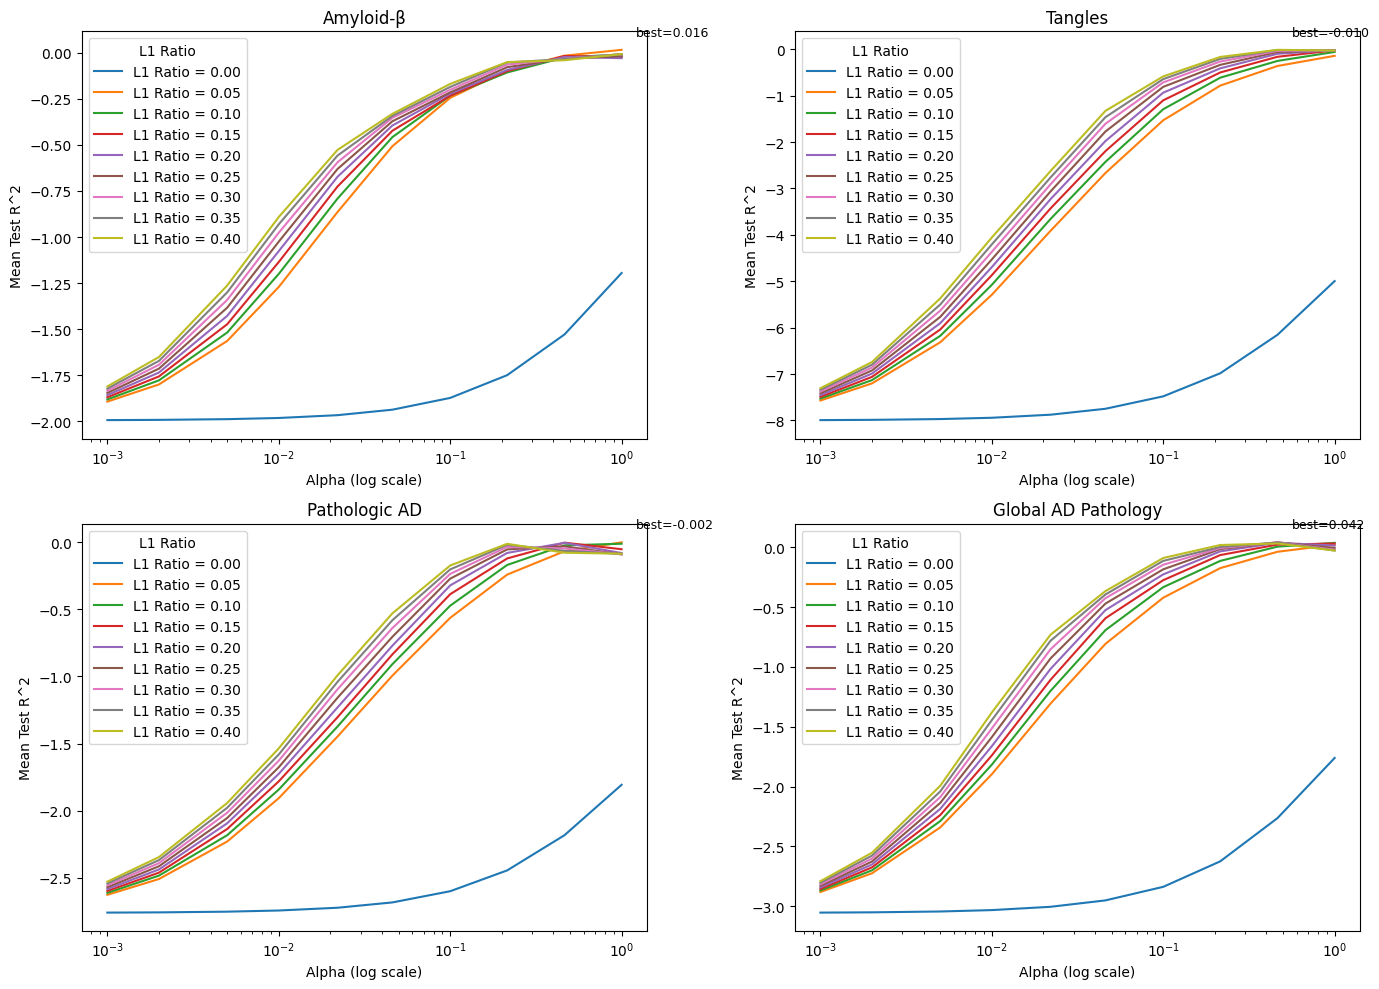

In [ ]:

# Target order and subplot title mapping
outcomes = ['amyloid', 'tangles', 'niareagansc', 'gpath']
title_map = {
    'amyloid': 'Amyloid-β',
    'tangles': 'Tangles',
    'gpath': 'Global AD Pathology',
    'niareagansc': 'Pathologic AD'
}

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Plot results for each outcome
for idx, outcome in enumerate(outcomes):
    cv_results = grid_search_results[outcome]["cv_results"].copy()
    ax = axes[idx]

    # Plot results for each outcome (loop follows predefined order)
    for l1_ratio in cv_results["param_l1_ratio"].unique():
        subset = cv_results[cv_results["param_l1_ratio"] == l1_ratio]
        ax.plot(subset["param_alpha"], subset["mean_test_score"], label=f"L1 Ratio = {l1_ratio:.2f}")

    # --- Added: print best mean_test_score (best R^2 point included) ---
    best_idx = cv_results["mean_test_score"].idxmax()
    best = cv_results.loc[best_idx]
    print(f"[{title_map[outcome]}] best mean_test_score = {best['mean_test_score']:.4f} "
          f"(alpha={best['param_alpha']}, l1_ratio={best['param_l1_ratio']})")

    # Annotate best point in the subplot
    ax.annotate(f"best={best['mean_test_score']:.3f}",
                xy=(best["param_alpha"], best["mean_test_score"]),
                xytext=(10, 10), textcoords="offset points", fontsize=9)

    ax.set_xscale("log")
    ax.set_xlabel("Alpha (log scale)")
    ax.set_ylabel("Mean Test R^2")
    ax.set_title(title_map[outcome])
    ax.legend(title="L1 Ratio")

plt.tight_layout()

# --- Save the Figure ---
fig_path = OUTPUT_DIR / "glm_grid_search_results.png"
plt.savefig(fig_path, dpi=300)
print(f"Figure saved to: {fig_path}")

plt.show()

## 1.3 Fit model with selected best parameters

In [ ]:
from sklearn.metrics import r2_score

# Define training/testing features
train_predictors = scaled_train_last.drop(columns=drop_vars)
test_predictors  = scaled_test_last.drop(columns=drop_vars)

# Define log file path
log_file_path = OUTPUT_DIR / "glm_performance_report.txt"

# Open file to write results
with open(log_file_path, "w") as f:
    f.write("GLM Elastic Net Performance Report\n")
    f.write("==================================\n\n")

    for outcome in ['amyloid', 'gpath', 'tangles', 'niareagansc']:
        # Prepare data
        train_outcome = scaled_train_last[outcome]
        test_outcome  = scaled_test_last[outcome]
        
        best_params = grid_search_results[outcome]["best_params"]
        alpha    = best_params["alpha"]
        l1_ratio = best_params["l1_ratio"]

        # Re-train model
        best_model = utils.ElasticNetRidgeSwitcher(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10000
        )
        best_model.fit(train_predictors, train_outcome)

        # Predict and Evaluate
        y_pred = best_model.predict(test_predictors)
        r2 = r2_score(test_outcome, y_pred)

        # Construct message
        msg = (
            f"Outcome: {outcome}\n"
            f"  Best Params: alpha={alpha}, l1_ratio={l1_ratio}\n"
            f"  Test R^2: {r2:.4f}\n"
            f"--------------------------------------------------\n"
        )
        
        # Print to console
        print(msg)
        
        # Write to file
        f.write(msg)

print(f"Performance report saved to: {log_file_path}")

Outcome: amyloid
  Best Params: alpha=1.0, l1_ratio=0.05
  Test R^2: -0.1888
--------------------------------------------------

Outcome: gpath
  Best Params: alpha=0.464, l1_ratio=0.3
  Test R^2: -0.0579
--------------------------------------------------

Outcome: tangles
  Best Params: alpha=0.464, l1_ratio=0.4
  Test R^2: 0.0439
--------------------------------------------------

Outcome: niareagansc
  Best Params: alpha=1.0, l1_ratio=0.05
  Test R^2: -0.0041
--------------------------------------------------

Performance report saved to: /Users/franklinbao/Desktop/ML/Codes/Modifications/AD_Github_Updated_Version/results/S2/glm_performance_report.txt
